In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import warnings
import os
import pandas as pd
import numpy as np
import modules.model as Model
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

## Công việc 2.2
* Phần này, ta sẽ đào tạo một **Comment sentiment model**.
* Chiến lược của ta sẽ như sau:
  * **Bước 1**: Tiến hành thay thế các từ trong comment bằng các từ ghép phổ biến phát sinh bởi N-Grams.
  * **Bước 2**: Tiếp theo, định nghĩa một vài vectorizer bằng **sklearn**.
  * **Bước 3**: Liệt kê các classifier model.
  * **Bước 4**: Với từng vectorizer đã liệt kê, sử dụng từng model classifier để đào tạo cross-validation với input là vectorizer tương ứng.
  * **Bước 5**: Lựa chọn các model và vectorizer phù hợp với dataset comment.
  * **Bước 6**: Thực hiện tunning hyperparams cho các model được chọn ở bước 5 bằng cross-validation.
  * **Bước 7**: Sau khi tunning và nhận được các hyperparams tốt nhất, tiến hành training lại nhưng không cross-validation.
  * **Bước 8**: Đánh giá bằng accuracy và ROC-AUC trên test data.
  * **Bước 9**: Lưu lại các model này thành file `*.pickle`.

Load training data.

In [3]:
X_train, y_train = Model.loadData("./data/data/train")
X_train = X_train.fillna("")

display(X_train, y_train)

,comment,nomalized_comment,emoji_decode
0,"Chất liệu bình thường, áo rộng so v...",bình_thường áo_rộng với xin đổi bả...,
1,Đúng với mô tả:đúng\nChất liệu:nỉ\n...,đúng nỉ đỏ xám bo tay lệch nhiều thừa,raised_hand
2,Đúng với mô tả:ko đúng lắm còn bị ra...,đúng lắm rách nhiều kiến riêng ổn m...,
3,10dd,,
4,hàng k đúng mẫu đặt mua,hàng không đúng mẫu đặt mua,
...,...,...,...
21741,Chất liệu:vải\nĐúng với mô tả:đúng\...,vải đúng ghi áo rất đẹp rất cuốn_hú...,
21742,Mk thấy áo k được đẹp lắm \n2 lớp n...,mình thấy áo không được đẹp lắm lơ...,
21743,Màu sắc:trắng\nChất liệu:gió\nĐúng ...,trắng gió giống không đẹp hợp giá ti...,
21744,GIẢM GIÁ KHỦNG - MUA SẮM LIỀN TAY\n ...,giảm_giá khủng mua_sắm liền_tay sale sa...,house_with_garden heart heart diamonds diamond...


,label
0,0
1,0
2,0
3,1
4,0
...,...
21741,1
21742,0
21743,0
21744,1


Ở project 2, ta đã đề cập đến N-Grams với tổ hợp 2, 3 và 4 từ ghép. Bây giờ ta sẽ tạo một DataFrame để lưu các từ ghép này, cột `freq_doc` là số comment chứa cụm từ đó, cột `freq` là tần số xuất hiện của từ ghép đó trên toàn bộ dataset comment. Tất cả được sắp xếp giảm dần theo `freq_doc`.

In [5]:
ngram_words = Model.getDashWords(X_train['nomalized_comment'], [2, 3, 4])

ngram_words

,freq_doc,freq
giao hàng,2261,2261
nên mua,2052,2052
hàng nhanh,1655,1655
giao hàng nhanh,1561,1561
áo đẹp,1436,1436
...,...,...
h toàn_quốc nhận chuyển_khoản,1,1
toàn_quốc nhận chuyển_khoản giao,1,1
nhận chuyển_khoản giao gấp,1,1
chuyển_khoản giao gấp ngày,1,1


In [7]:
print(len(ngram_words[ngram_words['freq_doc'] >= 10]))
print(len(ngram_words[ngram_words['freq_doc'] >= 20]))

4304
1833


> **Nhận xét**:
> * Có tổng cộng 4304 từ ghép mà có hơn 10 comment chứa sự xuất hiện của chúng.
> * Có tổng cộng 1833 từ ghép mà có hơn 20 comment chứa sự xuất hiện của chúng.

Bây giờ, ta tạo ra hai feature là `dash_comment` và `dash_comment_min_20`, hai cột này lần lượt chứa các comment mà các khoảng trắng trong từ các từ ghép được thay thế bằng kí tự `_`.

Ở đây `dash_comment` sẽ thay toàn toàn bộ các từ ghép phát sinh bởi N-Grams. 

`dash_comment_min_20` chỉ thay thế các từ ghép mà phải có ít nhất 20 comment chứa chúng. Nhưng bước này ta đã thực hiện thừa vì các vectorizing của **sklearn** hỗ trợ ta việc này.

In [7]:
X_train['dash_comment'] = Model.replaceInNGrams(X_train['nomalized_comment'], [2, 3, 4], ngram_words, 'freq_doc')
X_train['dash_comment_min_20'] = Model.replaceInNGrams(X_train['nomalized_comment'], [2, 3, 4], ngram_words, 'freq_doc', 20)

X_train

,comment,nomalized_comment,emoji_decode,dash_comment,dash_comment_min_20
0,"Chất liệu bình thường, áo rộng so v...",bình_thường áo_rộng với xin đổi bả...,,bình_thường áo_rộng với xin đổi bả...,bình_thường áo_rộng với xin đổi bả...
1,Đúng với mô tả:đúng\nChất liệu:nỉ\n...,đúng nỉ đỏ xám bo tay lệch nhiều thừa,raised_hand,đúng nỉ đỏ xám bo tay lệch nhiều thừa,đúng nỉ đỏ xám bo tay lệch nhiều thừa
2,Đúng với mô tả:ko đúng lắm còn bị ra...,đúng lắm rách nhiều kiến riêng ổn m...,,đúng lắm rách nhiều kiến riêng ổn m...,đúng lắm rách nhiều kiến riêng ổn m...
3,10dd,,,,
4,hàng k đúng mẫu đặt mua,hàng không đúng mẫu đặt mua,,hàng không đúng mẫu đặt mua,hàng không đúng mẫu đặt mua
...,...,...,...,...,...
21741,Chất liệu:vải\nĐúng với mô tả:đúng\...,vải đúng ghi áo rất đẹp rất cuốn_hú...,,vải đúng ghi áo rất đẹp rất cuốn_hú...,vải đúng ghi áo rất đẹp rất cuốn_hú...
21742,Mk thấy áo k được đẹp lắm \n2 lớp n...,mình thấy áo không được đẹp lắm lơ...,,mình thấy áo không được đẹp lắm lơ...,mình thấy áo không được đẹp lắm lơ...
21743,Màu sắc:trắng\nChất liệu:gió\nĐúng ...,trắng gió giống không đẹp hợp giá ti...,,trắng gió giống không đẹp hợp giá ti...,trắng gió giống không đẹp hợp giá ti...
21744,GIẢM GIÁ KHỦNG - MUA SẮM LIỀN TAY\n ...,giảm_giá khủng mua_sắm liền_tay sale sa...,house_with_garden heart heart diamonds diamond...,giảm_giá khủng mua_sắm liền_tay sale sa...,giảm_giá khủng mua_sắm liền_tay sale sa...


Dưới đây ta lần lượt phát sinh các vectorizer bằng cả Bag of Words và TG-IDF với các `min_df` khác nhau là 1, 5, 10 và 20.

In [9]:
vectorizers = [
    ("Bag of Words", Model.vectorizer(X_train['dash_comment'], 'bow')),
    ("TF-IDF", Model.vectorizer(X_train['dash_comment'], 'tfidf')),
    ("Bag of Words- [min_df: 5]", Model.vectorizer(X_train['dash_comment'], 'bow', 5)),
    ("TF-IDF- [min_df: 5]", Model.vectorizer(X_train['dash_comment'], 'tfidf', 5)),
    ("Bag of Words - [min_df: 10]", Model.vectorizer(X_train['dash_comment'], 'bow', 10)),
    ("TF-IDF - [min_df: 10]", Model.vectorizer(X_train['dash_comment'], 'tfidf', 10)),
    ("Bag of Words - [min_df: 20]", Model.vectorizer(X_train['dash_comment'], 'bow', 20)),
    ("TF-IDF - [min_df: 20]", Model.vectorizer(X_train['dash_comment'], 'tfidf', 20))
]

ix = 0
# Access the vectorizer object from the tuple returned by Model.vectorizer()
print(len(vectorizers[ix][1][0].get_feature_names_out()))
print(vectorizers[ix][1][0].get_feature_names_out()[:100])
pd.DataFrame(data=vectorizers[ix][1][1].toarray(), columns=vectorizers[ix][1][0].get_feature_names_out())

7647
['ab' 'able' 'ac' 'acid' 'action' 'ado' 'aeon' 'agenda' 'aha' 'airtime'
 'al' 'album' 'aloha' 'alpha' 'am' 'amazing' 'amazon' 'amply' 'an'
 'an_nhiên' 'an_toàn' 'an_tâm' 'an_ủi' 'ana' 'and' 'android' 'ang' 'anh'
 'anh_chị' 'anh_chị_em' 'anh_em' 'anh_minh_hoạ' 'anime' 'anklet' 'any'
 'anyway' 'ao' 'ap' 'aply' 'archive' 'are' 'arena' 'art' 'as' 'asociate'
 'asociates' 'at' 'atm' 'au' 'audio' 'audio_thiết' 'auth' 'authentic'
 'auto' 'avatar' 'avocado' 'awards' 'ay' 'ba' 'ba_ba' 'ba_bốn' 'ba_lỗ'
 'ba_má' 'baby' 'back' 'bai' 'bam' 'ban' 'ban_cai' 'ban_công' 'ban_ngày'
 'ban_đêm' 'ban_đêm_ngày' 'ban_đầu' 'bang' 'banh' 'bank' 'basic' 'bat'
 'bay' 'bd' 'be' 'be_be' 'beautiful' 'because' 'beige' 'believe' 'beloved'
 'ben' 'berlin' 'best' 'bestseler' 'beta' 'beter' 'bf' 'bi' 'bi_kịch'
 'bi_thương' 'big' 'bil']


,ab,able,ac,acid,action,ado,aeon,agenda,aha,airtime,...,ức,ức_chế,ứn,ứng,ứng_dụng,ứng_xử,ừ_vậy,ừa,ừm,ửng
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21744,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> **Nhận xét**:
> * Với vectorizer dầu tiên, ta thiết lập `min_df=1` mặc định của **sklearn** thì ta có tổng cộng 7647 từ (kể cả từ ghép).
> * Số lượng này ổn, thích hợp để đào tạo.

In [14]:
ix = 3
print(len(vectorizers[ix][1][0].get_feature_names_out()))
print(vectorizers[ix][1][0].get_feature_names_out()[:100])
pd.DataFrame(data=vectorizers[ix][1][1].toarray(), columns=vectorizers[ix][1][0].get_feature_names_out())

2129
['ac' 'al' 'am' 'an' 'and' 'anh' 'anh_em' 'ao' 'ap' 'ba' 'bai' 'ban'
 'ban_đầu' 'basic' 'bay' 'be' 'bi' 'big' 'binh' 'bit' 'biết' 'biển'
 'black' 'blazer' 'bo' 'body' 'bomber' 'bong' 'boxy' 'brand' 'buf' 'bung'
 'but' 'buôn' 'buôn_bán' 'buồn' 'buồn_cười' 'buộc' 'by' 'bye' 'bài'
 'bài_học' 'bàn' 'bàn_cãi' 'bàn_tay' 'bám' 'bán' 'bánh' 'báo' 'báo_cáo'
 'bát' 'bâu' 'bây' 'bây_giờ' 'bão' 'bé' 'béo' 'bê' 'bì' 'bình' 'bình_luận'
 'bình_thường' 'bí' 'bít' 'bò' 'bó' 'bóc' 'bóng' 'bóp' 'bông' 'bù' 'bùn'
 'băng' 'bơ' 'bơi' 'bước' 'bướm' 'bạc' 'bạc_màu' 'bạn' 'bạn_bè' 'bản'
 'bản_thân' 'bảng' 'bảo' 'bảo_vệ' 'bấm' 'bất' 'bất_kỳ' 'bất_ngờ'
 'bất_tiện' 'bấy' 'bẩn' 'bận' 'bật' 'bắc' 'bắp_tay' 'bắt' 'bắt_đầu' 'bằng']


,ac,al,am,an,and,anh,anh_em,ao,ap,ba,...,ống_quần,ổn,ổn_áp,ổn_định,ờm,ủa,ủng,ủng_hộ,ứng,ứng_dụng
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.299850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.136656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> **Nhận xét**:
> * Với `min_df=5`, không gian nhỏ hơn từ 7647 xuống còn hơn 2129 từ.

In [16]:
ix = 5
print(len(vectorizers[ix][1][0].get_feature_names_out()))
print(vectorizers[ix][1][0].get_feature_names_out()[:100])
pd.DataFrame(data=vectorizers[ix][1][1].toarray(), 
             columns=vectorizers[ix][1][0].get_feature_names_out())

1401
['an' 'and' 'anh' 'anh_em' 'ao' 'ap' 'ba' 'ban' 'ban_đầu' 'bay' 'be' 'bi'
 'binh' 'bit' 'biết' 'biển' 'black' 'blazer' 'bo' 'body' 'bong' 'boxy'
 'brand' 'bung' 'buôn_bán' 'buồn' 'buộc' 'bài' 'bàn' 'bàn_cãi' 'bàn_tay'
 'bám' 'bán' 'báo' 'bát' 'bây' 'bây_giờ' 'bé' 'béo' 'bình' 'bình_luận'
 'bình_thường' 'bí' 'bít' 'bò' 'bó' 'bóc' 'bóng' 'bông' 'bù' 'bơ' 'bơi'
 'bạc' 'bạn' 'bạn_bè' 'bản' 'bản_thân' 'bảng' 'bảo' 'bảo_vệ' 'bấm'
 'bất_kỳ' 'bất_ngờ' 'bẩn' 'bận' 'bắc' 'bắp_tay' 'bắt' 'bằng' 'bề' 'bền'
 'bịp' 'bọc' 'bỏ' 'bỏ_qua' 'bố' 'bồng' 'bổ' 'bộ' 'bục' 'bụi' 'bụng' 'bữa'
 'bự' 'bực' 'ca' 'cai' 'cam' 'can' 'canh' 'cao' 'cao_cấp' 'cardigan' 'cg'
 'chan' 'chang' 'chat' 'che' 'che_chắn' 'check']


,an,and,anh,anh_em,ao,ap,ba,ban,ban_đầu,bay,...,ấm,ấm_áp,ẩu,ốm,ống,ổn,ổn_áp,ủa,ủng,ủng_hộ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.299850,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.136656,0.0,0.0,0.0,0.0
21743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


> **Nhận xét**:
> * Với `min_df=10`, lúc này chỉ còn hơn 1,400 từ và từ ghép thỏa phổ biến trên dataset comment.
> * Số lượng này khá nhỏ so với hơn 21000 comment

In [18]:
ix = 7
print(len(vectorizers[ix][1][0].get_feature_names_out()))
print(vectorizers[ix][1][0].get_feature_names_out()[-100:])
pd.DataFrame(data=vectorizers[ix][1][1].toarray(), 
             columns=vectorizers[ix][1][0].get_feature_names_out())

899
['xỏ' 'xốp' 'xứng' 'xứng_đáng' 'xứng_đáng_giá' 'yes' 'yên_tâm' 'yêu'
 'yêu_cầu' 'áo' 'áo_dài' 'áo_gió' 'áo_khoác' 'áo_rộng' 'áo_ấm' 'áp' 'ép'
 'êm' 'ít' 'ôi' 'ôm' 'ăn' 'đang' 'đau' 'đem' 'đen' 'đi' 'điên' 'điều'
 'điểm' 'điện_thoại' 'đoạn' 'đung' 'đáng' 'đáng_giá' 'đánh' 'đánh_giá'
 'đòi_hỏi' 'đóng' 'đóng_gói' 'đô' 'đôi' 'đông' 'đúng' 'đăng' 'đơn' 'đưa'
 'đường' 'được' 'đạt' 'đất' 'đấy' 'đầu' 'đầu_tiên' 'đầy' 'đầy_đủ' 'đậm'
 'đắt' 'đằng' 'đặc' 'đặc_biệt' 'đặt' 'đặt_hàng' 'đẹp' 'đều' 'đểu' 'đệm'
 'đỉnh' 'định' 'đọc' 'đỏ' 'đối' 'đống' 'đồ' 'đồng' 'đồng_tiền' 'đổ' 'đổi'
 'độ' 'đội' 'độn' 'đời' 'đỡ' 'đợi' 'đợt' 'đủ' 'đứa' 'đứng' 'đứt' 'đừng'
 'ưng' 'ảnh' 'ảo' 'ấm' 'ấm_áp' 'ẩu' 'ống' 'ổn' 'ổn_áp' 'ủng_hộ']


,and,anh,anh_em,ao,ba,ban_đầu,bay,be,biết,biển,...,ưng,ảnh,ảo,ấm,ấm_áp,ẩu,ống,ổn,ổn_áp,ủng_hộ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299850,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
21742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141977,0.0,0.0
21743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
21744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


> **Nhận xét**:
> * Với `min_df=20`, thì chỉ còn 899, con số này thì quá nhỏ so với hơn 21,000 comment, khả năng cao vectorizer này không đủ khả năng để đại diện cho dataset comment.

Bây giờ, ta liệt kê một vài clasifier model phổ biến và dùng các vectorizer có `min_df` lần lượt là 1 và 5.

Ta tiến hành train bằng cross-validation và chia training data làm 10 phần - sau đó lưu vào biến `cv` để đảm bảo dữ liệu khi cross-validation công bằng cho toàn bộ model. 

In [11]:
lst_models = [
    ('Logistic Regression - [solver: lbfgs]', LogisticRegression(solver='lbfgs')),
    ('Logistic Regression - [solver: liblinear]', LogisticRegression(solver='liblinear')),
    ('Logistic Regression - [solver: newton-cg]', LogisticRegression(solver='newton-cg')),
    ('KNN - [n_neighbors: 2]', KNeighborsClassifier(n_neighbors=2)),
    ('KNN - [n_neighbors: 3]', KNeighborsClassifier(n_neighbors=3)),
    ('SVC - [kernel: linear]', SVC(kernel='linear', random_state=42)),
    ('SVC - [kernel: poly]', SVC(kernel='poly', random_state=42)),
    ('SVC - [kernel: rbf]', SVC(kernel='rbf', random_state=42)),
    ('SVC - [kernel: sigmoid]', SVC(kernel='sigmoid', random_state=42)),
    ('Bernoulli', BernoulliNB()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(eval_metric='mlogloss'))
]

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [13]:
original_models = Model.train(lst_models, vectorizers, y_train, cv)

original_models

Bag of Words:
	Model Logistic Regression - [solver: lbfgs] has been trained in 3.11 seconds
	Model Logistic Regression - [solver: liblinear] has been trained in 1.74 seconds
	Model Logistic Regression - [solver: newton-cg] has been trained in 3.09 seconds
	Model KNN - [n_neighbors: 2] has been trained in 177.27 seconds
	Model KNN - [n_neighbors: 3] has been trained in 177.33 seconds
	Model SVC - [kernel: linear] has been trained in 593.91 seconds
	Model SVC - [kernel: poly] has been trained in 853.27 seconds
	Model SVC - [kernel: rbf] has been trained in 784.83 seconds
	Model SVC - [kernel: sigmoid] has been trained in 334.06 seconds
	Model Bernoulli has been trained in 0.30 seconds
	Model Random Forest has been trained in 626.20 seconds
	Model XGBoost has been trained in 8.06 seconds
TF-IDF:
	Model Logistic Regression - [solver: lbfgs] has been trained in 2.42 seconds
	Model Logistic Regression - [solver: liblinear] has been trained in 0.77 seconds
	Model Logistic Regression - [solver

,vectorizer,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,TF-IDF,SVC - [kernel: rbf],0.948159,0.868850,0.079309,0.000302,0.005912,0.981562,0.932872,0.048690,0.000548,0.003334,41.336350
1,TF-IDF- [min_df: 5],SVC - [kernel: rbf],0.943704,0.868758,0.074946,0.000603,0.006330,0.979688,0.932789,0.046899,0.000607,0.003760,36.315808
2,TF-IDF - [min_df: 10],SVC - [kernel: rbf],0.941246,0.868160,0.073086,0.000563,0.006926,0.978759,0.932396,0.046363,0.000243,0.004091,33.615926
3,TF-IDF - [min_df: 20],SVC - [kernel: rbf],0.937082,0.867425,0.069657,0.000454,0.006848,0.976894,0.931081,0.045813,0.000373,0.004487,32.286670
4,TF-IDF- [min_df: 5],SVC - [kernel: poly],0.971254,0.860802,0.110452,0.000483,0.006662,0.988897,0.918764,0.070133,0.000380,0.004018,71.669219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,TF-IDF- [min_df: 5],KNN - [n_neighbors: 3],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007589
92,TF-IDF - [min_df: 10],KNN - [n_neighbors: 2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006124
93,TF-IDF - [min_df: 10],KNN - [n_neighbors: 3],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007394
94,TF-IDF - [min_df: 20],KNN - [n_neighbors: 2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005234


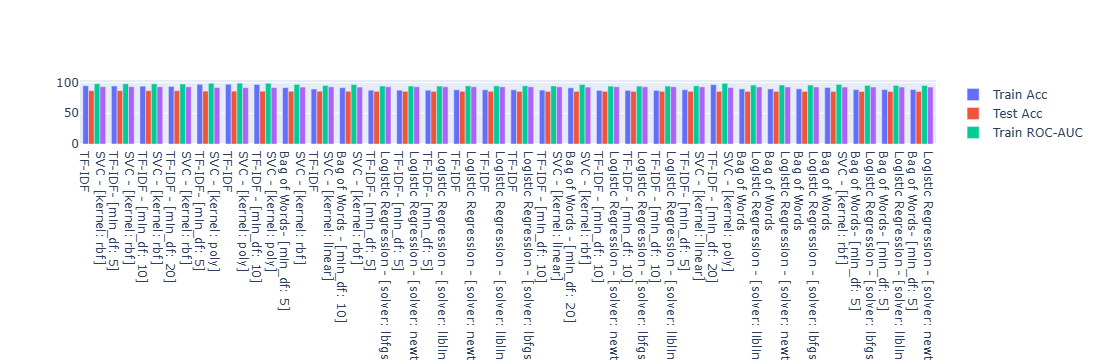

In [23]:
Model.emojiEvaluationGroupedBarChart(original_models, 30)

> **Nhận xét**:
> * Ta thấy 5 model đầu tiên có `train_acc` và `test_acc` cao, tuy nhiên ở model SVC sử dụng `kernel='poly` có sự xuất hiện overfitting ở đây khi `train_acc` và `test_acc` chênh lệch 11%.
> * Ở đây, ta có thể bỏ qua `train/test_roc_auc` vì ở project 2 đã cân bằng input đầu vào + `train/test_acc` cao nên ta không cần xem các con số này nữa.
> * Ở các model này, vectorizer phổ biến là TF-IDF có `min_df=5`.

Ở đây, vì đã nêu ở đầu là sẽ ưu tiên cho hai thuật toán là Logistic Regression và SVC. Hai dòng code mà đề tài comment bên dưới là các hyper-params được mọi người thường hay sử dụng để tunning cho model.

In [31]:
# 'gamma': [0.0001, 0.001, 0.01, 1.0, 10],
# 'C': [0.1, 0.5, 1.0, 10, 25, 50, 75, 100]

lst_tunning_models = [
    ('Logistic Regression - [solver: liblinear]', LogisticRegression(solver='liblinear'), {
        'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'penalty': ['none', 'l1', 'l2', 'elasticnet']
        }),
    ('Logistic Regression - [solver: newton-cg]', LogisticRegression(solver='newton-cg'), {
        'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'penalty': ['none', 'l1', 'l2', 'elasticnet']
        }),
    ('Logistic Regression - [solver: lbfgs]', LogisticRegression(solver='lbfgs'), {
        'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'penalty': ['none', 'l1', 'l2', 'elasticnet']
        }),
    ('SVC - [kernel: rbf]', SVC(kernel='rbf', random_state=42), {
        'probability': [True]
        }),
    ('SVC - [kernel: linear]', SVC(kernel='linear', random_state=42), {
        'probability': [True]
        }),
    ('SVC - [kernel: poly]', SVC(kernel='poly', random_state=42), {
        'probability': [True]
        })
]

In [33]:
lst_tunning_models = Model.trainTunningModel(lst_tunning_models, vectorizers[3][1][1], y_train, cv)

lst_tunning_models

Model Logistic Regression - [solver: liblinear] has been tunned in 5.29 seconds
Model Logistic Regression - [solver: newton-cg] has been tunned in 677.54 seconds
Model Logistic Regression - [solver: lbfgs] has been tunned in 16.06 seconds
Model SVC - [kernel: rbf] has been tunned in 1,705.12 seconds
Model SVC - [kernel: linear] has been tunned in 902.87 seconds
Model SVC - [kernel: poly] has been tunned in 3,723.13 seconds


[('Logistic Regression - [solver: liblinear]',
  LogisticRegression(solver='liblinear')),
 ('Logistic Regression - [solver: newton-cg]',
  LogisticRegression(solver='newton-cg')),
 ('Logistic Regression - [solver: lbfgs]', LogisticRegression()),
 ('SVC - [kernel: rbf]', SVC(probability=True, random_state=42)),
 ('SVC - [kernel: linear]',
  SVC(kernel='linear', probability=True, random_state=42)),
 ('SVC - [kernel: poly]',
  SVC(kernel='poly', probability=True, random_state=42))]

Bây giờ, ta sẽ đào tạo lại các model sau khi tunning hyper-params và đào tạo trên toàn bộ training data.

In [35]:
tunning_models = Model.train(lst_tunning_models, [vectorizers[3]], y_train, cv)

TF-IDF- [min_df: 5]:
	Model Logistic Regression - [solver: liblinear] has been trained in 0.59 seconds
	Model Logistic Regression - [solver: newton-cg] has been trained in 1.56 seconds
	Model Logistic Regression - [solver: lbfgs] has been trained in 0.95 seconds
	Model SVC - [kernel: rbf] has been trained in 1,938.56 seconds
	Model SVC - [kernel: linear] has been trained in 1,059.71 seconds
	Model SVC - [kernel: poly] has been trained in 26,202.10 seconds


In [37]:
tunning_models

,vectorizer,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,TF-IDF- [min_df: 5],SVC - [kernel: rbf],0.943704,0.868758,0.074946,0.000603,0.006330,0.979688,0.932789,0.046899,0.000607,0.003760,157.616490
1,TF-IDF- [min_df: 5],SVC - [kernel: poly],0.971254,0.860802,0.110452,0.000483,0.006662,0.988897,0.918764,0.070133,0.000380,0.004018,2276.070188
2,TF-IDF- [min_df: 5],Logistic Regression - [solver: lbfgs],0.875834,0.857399,0.018435,0.000824,0.006267,0.944053,0.931327,0.012726,0.000271,0.002995,0.080435
3,TF-IDF- [min_df: 5],Logistic Regression - [solver: newton-cg],0.875834,0.857399,0.018435,0.000811,0.006267,0.944052,0.931326,0.012726,0.000272,0.002995,0.140710
4,TF-IDF- [min_df: 5],Logistic Regression - [solver: liblinear],0.875824,0.857399,0.018425,0.000802,0.006267,0.944052,0.931324,0.012728,0.000271,0.002994,0.043575
5,TF-IDF- [min_df: 5],SVC - [kernel: linear],0.883810,0.856525,0.027285,0.000680,0.004833,0.947292,0.930779,0.016513,0.000269,0.003430,80.926209


Bây giờ, ta sẽ load dữ liệu test data lên để tiến hành kiểm thử.

In [59]:
# Bước 1: Load dữ liệu
X_test, y_test = Model.loadData("./data/data/test")

# Bước 2: Lọc bỏ các dòng chứa NaN hoặc không phải chuỗi trong 'nomalized_comment'
valid_mask = X_test['nomalized_comment'].apply(lambda x: isinstance(x, str))
X_test = X_test[valid_mask].copy()
y_test = y_test.loc[X_test.index].copy()  # Giữ đồng bộ y_test

# Bước 3: Tạo n-gram từ bình luận
X_test['dash_comment'] = Model.replaceInNGrams(
    X_test['nomalized_comment'],
    [2, 3, 4],
    ngram_words,
    'freq_doc'
)

# Bước 4: Chuẩn hóa kiểu Unicode (dạng NFC)
X_test['dash_comment'] = Model.convertToNFX(X_test['dash_comment'], 'NFC')

# Bước 5: Vector hóa với TF-IDF (phải đảm bảo `vectorizers[3][1][0]` là bộ biến đổi đúng)
tfidf_test_comment = vectorizers[3][1][0].transform(X_test['dash_comment'])

In [61]:
best_models = Model.evaluation(lst_tunning_models, vectorizers[3][1][1], y_train, tfidf_test_comment, y_test)

best_models

,model,train_acc,test_acc,train_roc_auc,test_roc_auc
0,SVC - [kernel: rbf],0.942472,0.866450,0.942459,0.866569
1,Logistic Regression - [solver: liblinear],0.875701,0.860606,0.875718,0.860714
2,Logistic Regression - [solver: newton-cg],0.875747,0.860606,0.875764,0.860714
3,Logistic Regression - [solver: lbfgs],0.875747,0.860606,0.875764,0.860714
4,SVC - [kernel: linear],0.883105,0.860281,0.883127,0.860365
5,SVC - [kernel: poly],0.970661,0.858766,0.970650,0.858968


> **Nhận xét**:
> * SVC - kernel: rbf: Hiệu suất cao nhất trên tập test, cân bằng giữa acc và roc_auc.
> * SVC - kernel: linear: Gần sát mô hình SVC RBF, đơn giản hơn, ít overfitting hơn mô hình poly.
> * Logistic Regression liblinear: Dễ huấn luyện, hiệu suất tốt và ổn định trên test set.
> * SVC poly dù có train_acc = 0.97, nhưng test_acc = 0.8588 và test_roc_auc = 0.8589 cho thấy dấu hiệu overfitting.
> * Các mô hình Logistic Regression khác có hiệu suất tương tự liblinear nhưng không vượt trội. 

Bây giờ ta sẽ lưu các model này cùng vectorizer TF-IDF `min_df=5` vào cùng một `SentimentModel`.

In [65]:
logistic_model = Model.SentimentModel(lst_tunning_models[0][1], vectorizers[3], y_train)
svc_rbf_model = Model.SentimentModel(lst_tunning_models[3][1], vectorizers[3], y_train)
svc_linear_model = Model.SentimentModel(lst_tunning_models[4][1], vectorizers[3], y_train)

print(logistic_model.info())
print(svc_rbf_model.info())
print(svc_linear_model.info())

LogisticRegression(solver='liblinear')
None
SVC(probability=True, random_state=42)
None
SVC(kernel='linear', probability=True, random_state=42)
None


Tiếp theo, ta sẽ đánh giá các model trên test data và training data và thực hiện trực quan hóa kết quả đánh giá.

In [67]:
X_train_transformed = Model.convertToNFX(X_train['dash_comment'], 'NFC')
X_test_transformed = Model.convertToNFX(X_test['dash_comment'], 'NFC')

              precision    recall  f1-score   support

    Negative       0.72      0.46      0.56     10830
    Positive       0.60      0.82      0.70     10916

    accuracy                           0.64     21746
   macro avg       0.66      0.64      0.63     21746
weighted avg       0.66      0.64      0.63     21746



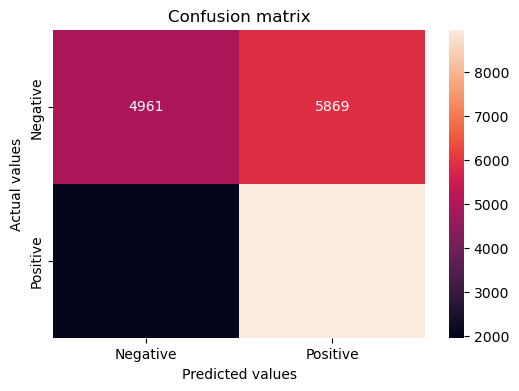

              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86      4674
    Positive       0.85      0.87      0.86      4566

    accuracy                           0.86      9240
   macro avg       0.86      0.86      0.86      9240
weighted avg       0.86      0.86      0.86      9240



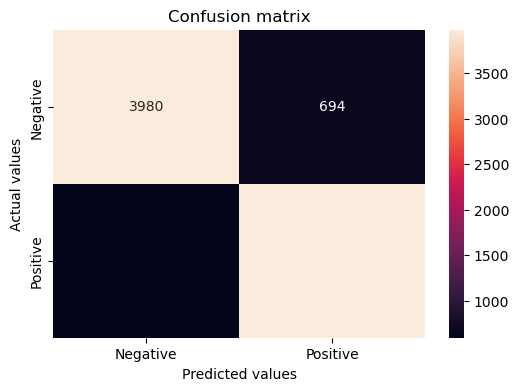

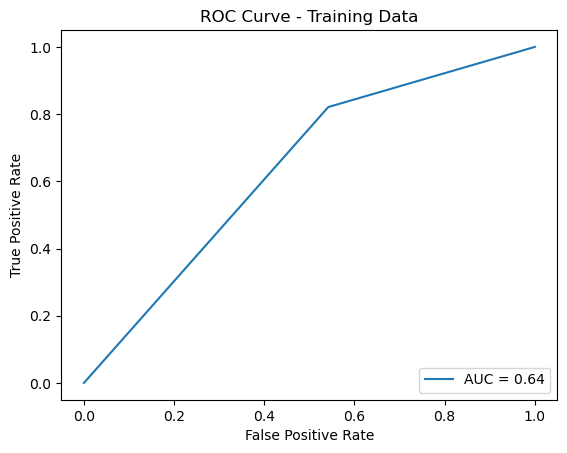

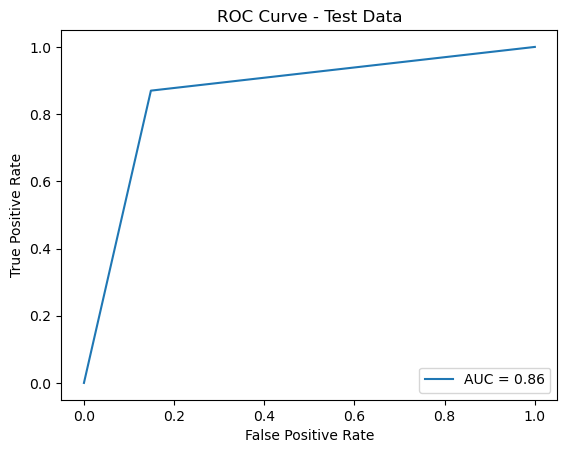

,input,output_proba,output_class
0,bình_thường áo_rộng với xin đổi bả...,"(0.5976688897590586, 0.40233111024094137)",0
1,đúng nỉ đỏ xám bo tay lệch nhiều thừa,"(0.599935196545104, 0.40006480345489603)",0
2,đúng lắm rách nhiều kiến riêng ổn m...,"(0.3659156865657769, 0.6340843134342231)",1
3,,"(0.5722478880774169, 0.42775211192258306)",0
4,hàng không đúng mẫu đặt mua,"(0.4913556431248681, 0.5086443568751319)",1
...,...,...,...
21741,vải đúng ghi áo rất đẹp rất cuốn_hú...,"(0.34640942920404494, 0.6535905707959551)",1
21742,mình thấy áo không được đẹp lắm lơ...,"(0.43317603901082935, 0.5668239609891706)",1
21743,trắng gió giống không đẹp hợp giá ti...,"(0.5825463390884963, 0.4174536609115037)",0
21744,giảm_giá khủng mua_sắm liền_tay sale sa...,"(0.2007047438581291, 0.7992952561418709)",1


,input,output_proba,output_class
0,hàng nhận khác với ảnh,"(0.9157162379507452, 0.08428376204925485)",0
1,áo đẹp chất vải mặc không nóng xíu luôn mua đư...,"(0.025341898029539345, 0.9746581019704607)",1
2,tạm ổn chuẩn ok cá sơ_chế xong bạn choi vô nồi...,"(0.19598840596994704, 0.804011594030053)",1
3,dày_dặn cầm nặng_tay be xịn,"(0.02358973500405137, 0.9764102649959486)",1
4,nhận áo không đúng đặt,"(0.9467387540291741, 0.053261245970825974)",0
...,...,...,...
9315,ok may nỗi ok,"(0.29050690253186673, 0.7094930974681333)",1
9316,giống hình vải mỏng không size l tay_áo_dài mỏ...,"(0.9925734584265932, 0.0074265415734068255)",0
9317,vải xốp màu trắng đẹp đúng form nên mua,"(0.3627268846836649, 0.6372731153163351)",1
9318,xám eo tôi đặt áo mong_muốn tay_áo_dài áo bự r...,"(0.6729659876575647, 0.3270340123424354)",0


In [73]:
# Logistic model
y_train_pred = logistic_model.predict(X_train['dash_comment'])
y_test_pred = logistic_model.predict(X_test['dash_comment'])

Model.confusionMatrix(y_train, y_train_pred['output_class'])
Model.confusionMatrix(y_test, y_test_pred['output_class'])

# Fix for ROC AUC calculation - using the correct method from sklearn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# For training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred['output_class'])
roc_auc_train = auc(fpr_train, tpr_train)
RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train).plot()
plt.title('ROC Curve - Training Data')
plt.show()

# For test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred['output_class'])
roc_auc_test = auc(fpr_test, tpr_test)
RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test).plot()
plt.title('ROC Curve - Test Data')
plt.show()


display(y_train_pred, y_test_pred)

> **Nhận xét**:
> * Đánh giá trên tập train:
> Mô hình học không tốt trên tập huấn luyện: Nhận diện nhãn Positive khá tốt (Recall 0.82) nhưng nhãn Negative thì kém (Recall chỉ 0.46). Có đến 5,869 mẫu tiêu cực bị đoán nhầm là tích cực.
> Độ chính xác (Accuracy) chỉ 0.64, AUC = 0.64 → khá thấp, cho thấy mô hình phân biệt hai lớp còn yếu.
> * Đánh giá trên tập test: AUC trên tập test = 0.86 → mô hình có khả năng phân biệt hai lớp tốt trên dữ liệu chưa từng thấy.
> * Tổng kết:
>   Mô hình Logistic Regression thể hiện rất kém trên tập train nhưng tốt trên tập test: Điều này thường do việc tiền xử lý dữ liệu hoặc phân chia tập train/test chưa đồng đều. Hoặc có thể là overfitting của mô hình khác gây ra sự chênh lệch, nhưng Logistic Regression lại đơn giản nên tránh được.
> Kết quả test ấn tượng: Precision/Recall/F1 cao và cân bằng cho cả hai lớp. Confusion matrix đẹp, số lượng nhầm lẫn thấp. ROC-AUC cao (0.86) → mô hình đáng tin cậy cho dự đoán thực tế.

              precision    recall  f1-score   support

    Negative       0.72      0.43      0.54     10830
    Positive       0.60      0.83      0.70     10916

    accuracy                           0.63     21746
   macro avg       0.66      0.63      0.62     21746
weighted avg       0.66      0.63      0.62     21746



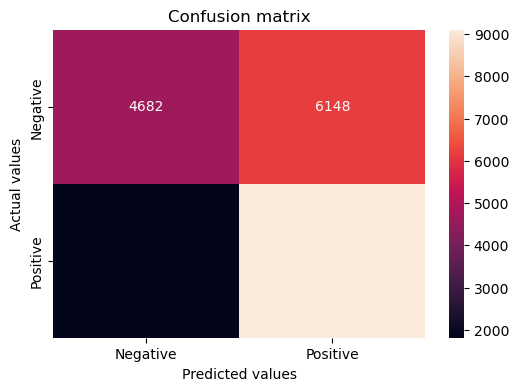

              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      4674
    Positive       0.86      0.88      0.87      4566

    accuracy                           0.87      9240
   macro avg       0.87      0.87      0.87      9240
weighted avg       0.87      0.87      0.87      9240



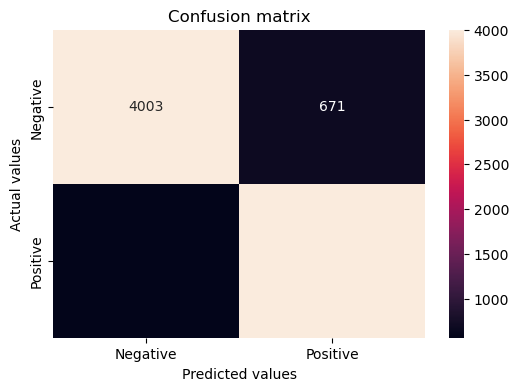

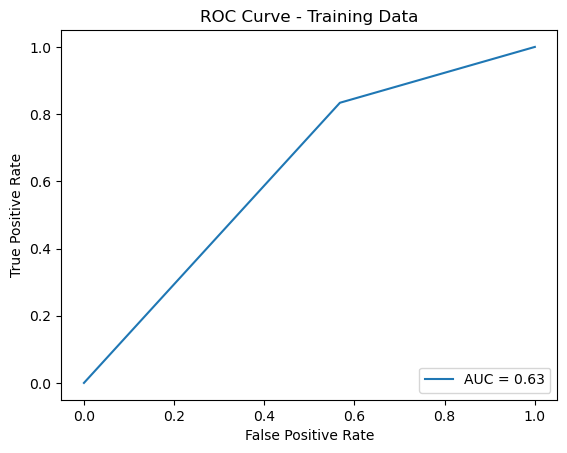

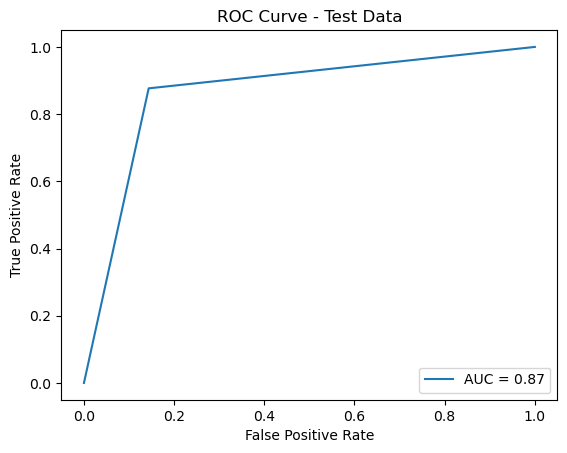

,input,output_proba,output_class
0,bình_thường áo_rộng với xin đổi bả...,"(0.5797571014166032, 0.42024289858339675)",0
1,đúng nỉ đỏ xám bo tay lệch nhiều thừa,"(0.5323634312467648, 0.46763656875323534)",0
2,đúng lắm rách nhiều kiến riêng ổn m...,"(0.3830507405983175, 0.6169492594016825)",1
3,,"(0.09821792752793564, 0.9017820724720643)",1
4,hàng không đúng mẫu đặt mua,"(0.5121002957878937, 0.48789970421210627)",0
...,...,...,...
21741,vải đúng ghi áo rất đẹp rất cuốn_hú...,"(0.2214232168746441, 0.778576783125356)",1
21742,mình thấy áo không được đẹp lắm lơ...,"(0.4846249129628698, 0.5153750870371303)",1
21743,trắng gió giống không đẹp hợp giá ti...,"(0.6409791566792046, 0.3590208433207954)",0
21744,giảm_giá khủng mua_sắm liền_tay sale sa...,"(0.16147071623434622, 0.8385292837656538)",1


,input,output_proba,output_class
0,hàng nhận khác với ảnh,"(0.911129627190312, 0.08887037280968814)",0
1,áo đẹp chất vải mặc không nóng xíu luôn mua đư...,"(0.019246702517645257, 0.9807532974823546)",1
2,tạm ổn chuẩn ok cá sơ_chế xong bạn choi vô nồi...,"(0.1293050238111366, 0.8706949761888633)",1
3,dày_dặn cầm nặng_tay be xịn,"(0.02502467821042259, 0.9749753217895774)",1
4,nhận áo không đúng đặt,"(0.9694902375339487, 0.030509762466051304)",0
...,...,...,...
9315,ok may nỗi ok,"(0.22688576336211388, 0.773114236637886)",1
9316,giống hình vải mỏng không size l tay_áo_dài mỏ...,"(0.9951073647300829, 0.004892635269917211)",0
9317,vải xốp màu trắng đẹp đúng form nên mua,"(0.17727010912020555, 0.8227298908797945)",1
9318,xám eo tôi đặt áo mong_muốn tay_áo_dài áo bự r...,"(0.7161214649187219, 0.2838785350812783)",0


In [75]:
# SVC RBF model
y_train_pred = svc_rbf_model.predict(X_train['dash_comment'])
y_test_pred = svc_rbf_model.predict(X_test['dash_comment'])

Model.confusionMatrix(y_train, y_train_pred['output_class'])
Model.confusionMatrix(y_test, y_test_pred['output_class'])

# Fix for ROC AUC calculation - using the correct method from sklearn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# For training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred['output_class'])
roc_auc_train = auc(fpr_train, tpr_train)
RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train).plot()
plt.title('ROC Curve - Training Data')
plt.show()

# For test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred['output_class'])
roc_auc_test = auc(fpr_test, tpr_test)
RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test).plot()
plt.title('ROC Curve - Test Data')
plt.show()


display(y_train_pred, y_test_pred)

> **Nhận xét**:
> * Đánh giá trên tập train:
> Mô hình có xu hướng thiên lệch về phía Positive, bỏ sót nhiều mẫu Negative.
> AUC = 0.63 → Kém, gần như ngẫu nhiên. Cho thấy mô hình học chưa tốt trên tập huấn luyện.
> * Đánh giá trên tập test:
> Số mẫu sai thấp, độ chính xác cao.
> AUC = 0.87 → Hiệu quả tốt, mô hình phân biệt rõ ràng giữa 2 lớp.
>   Mô hình cân bằng tốt giữa các lớp khi đánh giá trên dữ liệu chưa thấy trước.
> * Tổng kết: Mô hình có thể overfitting nhẹ (học chưa tốt trên tập huấn luyện nhưng lại rất tốt trên tập kiểm tra). Tuy nhiên, vì hiệu suất kiểm tra cao nên có thể chấp nhận được nếu tập kiểm tra đủ đại diện.

              precision    recall  f1-score   support

    Negative       0.67      0.45      0.54     10830
    Positive       0.59      0.78      0.67     10916

    accuracy                           0.62     21746
   macro avg       0.63      0.62      0.60     21746
weighted avg       0.63      0.62      0.61     21746



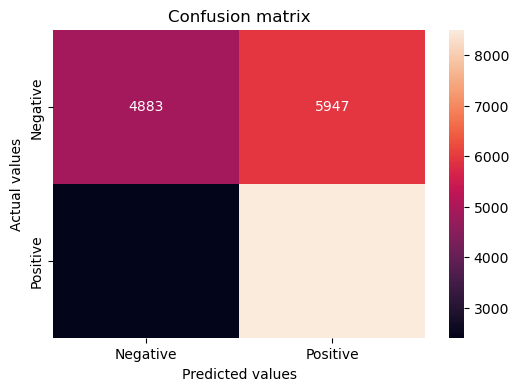

              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86      4674
    Positive       0.85      0.87      0.86      4566

    accuracy                           0.86      9240
   macro avg       0.86      0.86      0.86      9240
weighted avg       0.86      0.86      0.86      9240



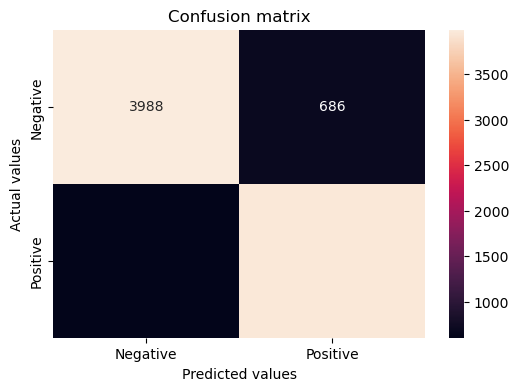

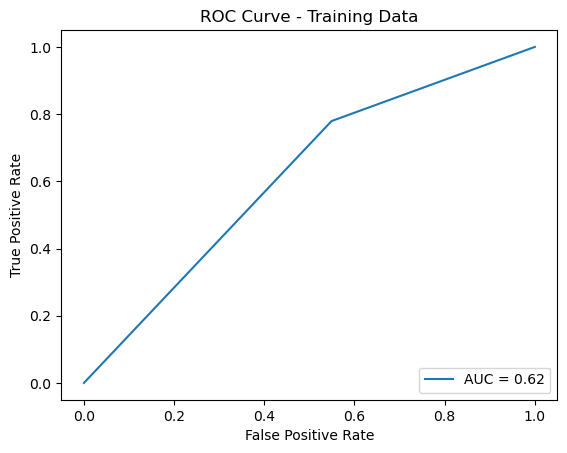

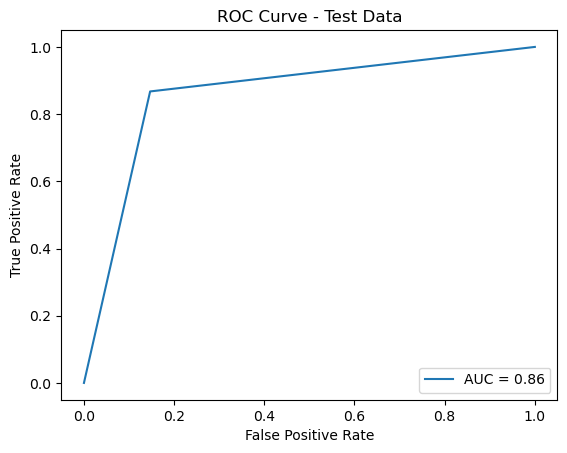

,input,output_proba,output_class
0,bình_thường áo_rộng với xin đổi bả...,"(0.6128874683417174, 0.38711253165828274)",0
1,đúng nỉ đỏ xám bo tay lệch nhiều thừa,"(0.5109508717584681, 0.48904912824153185)",0
2,đúng lắm rách nhiều kiến riêng ổn m...,"(0.41067842190655873, 0.5893215780934413)",1
3,,"(0.618395471505578, 0.38160452849442206)",0
4,hàng không đúng mẫu đặt mua,"(0.4404064679218462, 0.5595935320781539)",1
...,...,...,...
21741,vải đúng ghi áo rất đẹp rất cuốn_hú...,"(0.2924497800888022, 0.7075502199111977)",1
21742,mình thấy áo không được đẹp lắm lơ...,"(0.42660698193932306, 0.5733930180606769)",1
21743,trắng gió giống không đẹp hợp giá ti...,"(0.6292402627481664, 0.3707597372518336)",0
21744,giảm_giá khủng mua_sắm liền_tay sale sa...,"(0.12607503548176677, 0.8739249645182331)",1


,input,output_proba,output_class
0,hàng nhận khác với ảnh,"(0.9275874231296095, 0.07241257687039032)",0
1,áo đẹp chất vải mặc không nóng xíu luôn mua đư...,"(0.009897471106650665, 0.9901025288933493)",1
2,tạm ổn chuẩn ok cá sơ_chế xong bạn choi vô nồi...,"(0.13361649664919614, 0.866383503350804)",1
3,dày_dặn cầm nặng_tay be xịn,"(0.01736668240415183, 0.9826333175958483)",1
4,nhận áo không đúng đặt,"(0.9643911746047923, 0.035608825395207745)",0
...,...,...,...
9315,ok may nỗi ok,"(0.20314215545463993, 0.79685784454536)",1
9316,giống hình vải mỏng không size l tay_áo_dài mỏ...,"(0.9961061301195618, 0.0038938698804380652)",0
9317,vải xốp màu trắng đẹp đúng form nên mua,"(0.32926178239113957, 0.6707382176088603)",1
9318,xám eo tôi đặt áo mong_muốn tay_áo_dài áo bự r...,"(0.7136821327686709, 0.2863178672313291)",0


In [77]:
# SVC linear  model
y_train_pred = svc_linear_model.predict(X_train['dash_comment'])
y_test_pred = svc_linear_model.predict(X_test['dash_comment'])

Model.confusionMatrix(y_train, y_train_pred['output_class'])
Model.confusionMatrix(y_test, y_test_pred['output_class'])

# Fix for ROC AUC calculation - using the correct method from sklearn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# For training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred['output_class'])
roc_auc_train = auc(fpr_train, tpr_train)
RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train).plot()
plt.title('ROC Curve - Training Data')
plt.show()

# For test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred['output_class'])
roc_auc_test = auc(fpr_test, tpr_test)
RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test).plot()
plt.title('ROC Curve - Test Data')
plt.show()


display(y_train_pred, y_test_pred)

> **Nhận xét**:
> * Có thể thấy, khả năng dự đoán còn kém trên các class positive. Nhiều comment thực chất là positive nhưng lại bị dự đoán nhầm sang negative.
> * Khả năng dự đoán trên class negative tốt hơn ở các model. Điều này có thể là do variance error. Ở project một, ta đã tách các comment có 4 đến 5 sao vào nhóm positive và còn lại thuộc class negative. Tuy nhiên điều này có thể sai:
>   * Thực chất có các comment 3 sao đôi khi là các khách hàng trung bình, họ không thích cũng như không ghét sản phẩm, lúc này bài toán của chúng ta có thể tách thành 3 class là **positive**, **neutral** và **negative** để hị vọng khả năng dự đoán của model tốt hơn.
>   * Do noise sample, lí do là có những comment măc dù về ngữ nghĩa là positive nhưng nó lại thuộc nhóm negative và ngược lại. Tức ta không tiền xử lí dữ liệu tốt. Tuy nhiên ta khó lòng giải quyết vì nó phụ thuộc vào đánh giá chủ quan của con người. Nhưng với khả năng hiện tại nhóm khó khắc phục được lỗi này.

Bây giờ ta sẽ lưu lại các model này cùng với vectorizer TF-IDF `min_df=5`. Ta cũng cần lưu lại file tập N-Grams các từ ghép tổ hợp từ 2, 3 và 4 từ để có thể tiến hành transform khi có dữ liệu mới. 

In [79]:
Model.saveByPickle(svc_rbf_model, "./models/svc_rbf_model_comments.pickle")
Model.saveByPickle(svc_linear_model, "./models/svc_linear_model_comments.pickle")
Model.saveByPickle(logistic_model, "./models/logistic_model_comments.pickle")

<modules.model.SentimentModel object at 0x0000024C86F55690> has been saved at ./models/svc_rbf_model_comments.pickle.
<modules.model.SentimentModel object at 0x0000024C8A15CE10> has been saved at ./models/svc_linear_model_comments.pickle.
<modules.model.SentimentModel object at 0x0000024D14D30B10> has been saved at ./models/logistic_model_comments.pickle.


In [85]:
ngram_words.to_csv("./modules/dependencies/ngrams.csv")